In [15]:
import sys
import os
sys.path.append("../src")
import llm_utils
import prompt_utils
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.filterwarnings('always') 
warnings.simplefilter(action='ignore')


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import math
from collections import defaultdict
import numpy as np
import matplotlib.colors as mcolors
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix, classification_report
import streamlit as st
# Set the default layout to wide mode
st.set_page_config(layout="wide")

# Global variables
cumulative_support = {
    'support_class_0': 0,
    'support_class_1': 0
}
model_count = 0

classes = ["War/Terror", "Conspiracy Theory", "Education", "Election Campaign", "Environment", 
              "Government/Public", "Health", "Immigration/Integration", 
              "Justice/Crime", "Labor/Employment", 
              "Macroeconomics/Economic Regulation", "Media/Journalism", "Religion", "Science/Technology", "Others"]

def load_model(url, extraction_func, metrics_calculation_func):
    df = pd.read_csv(url)

    if "multi" not in url: #Ignore "Others" class for binary classification
        predictions_per_class, confusion_matrices, binary_classification_reports, multilabel_classification_reports = metrics_calculation_func(df, classes[0:-1], extraction_func)
    else:
        predictions_per_class, confusion_matrices, binary_classification_reports, multilabel_classification_reports = metrics_calculation_func(df, classes, extraction_func)
    data = {"confusion_matrices": confusion_matrices, "binary_classification_reports": binary_classification_reports, "multilabel_classification_reports": multilabel_classification_reports}

    if ((binary_classification_reports[['support_class_0', 'support_class_1']].iloc[0:-1] < 55).any(axis=1).any()) and ("multi" not in url):
        print("There are rows with NaN values in either 'support_class_0' or 'support_class_1'.")
        print("url: ", url)
        print("binary_classification_reports:")
        print(binary_classification_reports)
        print("--------------------")

    # Update the global variable with the sum of support values from the current model
    cumulative_support['support_class_0'] += binary_classification_reports['support_class_0'].mean()
    cumulative_support['support_class_1'] += binary_classification_reports['support_class_1'].mean()
    
    global model_count
    # Increment the model count
    model_count += 1

    return data, predictions_per_class

# ------------------------------
### Vicuna 4bit 
# ------------------------------

# Without context and classification only
## Example:
    ### Human: Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\n\nTweet: {tweet_text}\n### Assistant:\nClass = 
without_context_classification_only, without_context_classification_only_predictions_per_class = load_model("../data/vicuna_4bit/generic_prompt_without_context_only_classification/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# Without context and classification only
## Example:
    ### Human: Give the tweet a binary class based on if it's about {label} or not.\n\nTweet: {tweet_text}\n### Assistant:\nClass: "
without_context_classification_only_v02, without_context_classification_only_v02_predictions_per_class = load_model("../data/vicuna_4bit/generic_prompt_without_context_only_classification_v02/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# Without context and classification only
## Example:
    ### Human: Assign 1 if the tweet is about {label}. Assign 0 if it is not about {label}.\n\nTweet: {tweet_text}\n### Assistant:\nClass: "
without_context_classification_only_v03, without_context_classification_only_v03_predictions_per_class = load_model("../data/vicuna_4bit/generic_prompt_without_context_only_classification_v03/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# without context and elaboration first
## Example:
    ### Human: Elaborate on whether you think the Tweet is about {label} or something else.\nTweet: {tweet_text}\n### Assistant:\nElaboration: 
    #Followup :\n Assign class 1 for {label} or 0 for not. \n###Assistant:\nClass:  
without_context_elaboration_first, without_context_elaboration_first_predictions_per_class = load_model("../data/vicuna_4bit/generic_prompt_without_context_elaboration_first/generic_test_0.csv", llm_utils.get_extraction_function("extract_last_float"), llm_utils.calculate_binary_metrics)

#with rules as context and classification only
## Example:
    ### Human: Based on rules, classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\n\nRules: {rules}\nTweet: {tweet_text}\n### Assistant:\nClass:
with_rules_classification_only, with_rules_classification_only_predictions_per_class = load_model("../data/vicuna_4bit/generic_prompt_with_rules_only_classification/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 2), llm_utils.calculate_binary_metrics)

# with rules as context and elaboration first
## Example:
    ### Human: Based on rules, elaborate whether you think the Tweet is about {label}.\nRules: {rules}\nTweet: {tweet_text}\n### Assistant:\nElaboration: 
    #Followup :\n Assign class 1 for {label} or 0 for not. \n###Assistant:\nClass: 
with_rules_elaboration_first, with_rules_elaboration_first_predictions_per_class = load_model("../data/vicuna_4bit/generic_prompt_with_rules_elaboration_first/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# without context and elaboration first v02
## Example:
    #prompt = f"### Human: Elaborate on whether you think the Tweet is about {label} or something else.\nTweet: {tweet_text}\n### Assistant:\nElaboration: "
    #followup = f"### Human: Based on the elaboration, classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nTweet: {tweet_text}\nElaboration: [ELABORATION]\n### Assistant:\nClass: "
without_context_elaboration_first_v02, without_context_elaboration_first_v02_predictions_per_class = load_model("../data/vicuna_4bit/generic_prompt_without_context_elaboration_first_v02/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# without context and elaboration first v03
## Example:
    #prompt = f"### Human: Elaborate on whether you think the Tweet is about {label} or something else.\nTweet: {tweet_text}\n### Assistant:\nElaboration: "
    #followup = f"### Human: Based on the elaboration, classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nTweet: {tweet_text}\nElaboration: [ELABORATION]\n### Assistant:\nClass: "
without_context_elaboration_first_v03, without_context_elaboration_first_v03_predictions_per_class = load_model("../data/vicuna_4bit/generic_prompt_without_context_elaboration_first_v03/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# without context and elaboration first v04
without_context_elaboration_first_v04, without_context_elaboration_first_v04_predictions_per_class = load_model("../data/vicuna_4bit/generic_prompt_without_context_elaboration_first_v04/generic_test_0.csv", llm_utils.get_extraction_function("extract_using_class_token", 1), llm_utils.calculate_binary_metrics)

# with few-shot prompts
#----------------------
# Only classification 1 pos example
## ### Human: Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nExample Tweet: {example_tweet}\nClass: 1\n\nTweet: {tweet_text}\nClass: "
few_shot_1_pos, few_shot_1_pos_predictions_per_class = load_model("../data/vicuna_4bit/generic_prompt_few_shot_prompt_only_classification_1_pos_example/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# Only classification 1 neg example
## ### Human: Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nExample Tweet: {example_tweet}\nClass: 0\n\nTweet: {tweet_text}\nClass: "
few_shot_1_neg, few_shot_1_neg_predictions_per_class = load_model("../data/vicuna_4bit/generic_prompt_few_shot_prompt_only_classification_1_neg_example/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# Only classification 1 random example
## ### Human: Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nExample Tweet: {example_tweet}\nClass: {example_tweet_label}\n\nTweet: {tweet_text}\nClass: "
few_shot_1_random, few_shot_1_random_predictions_per_class = load_model("../data/vicuna_4bit/generic_prompt_few_shot_prompt_only_classification_1_random_example/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# Only classification 3 random example
## ### Human: Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nExample Tweet: {example_tweet}\nClass: {example_tweet_label1}\nExample Tweet: {example_tweet2}\nClass: {example_tweet_label2}\nExample Tweet: {example_tweet3}\nClass: {example_tweet_label3}\n\nTweet: {tweet_text}\nClass:
few_shot_3_random, few_shot_3_random_predictions_per_class = load_model("../data/vicuna_4bit/generic_prompt_few_shot_prompt_only_classification_3_random_example/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# Only classification 3 random example v02
## ### Human: Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\n Tweet: {example_tweet}\n### Assistant:\nClass: {example_tweet_label1}\nTweet: {example_tweet2}\n### Assistant:\nClass: {example_tweet_label2}\nTweet: {example_tweet3}\n### Assistant:\nClass: {example_tweet_label3}\n\nTweet: {tweet_text}\n### Assistant:\nClass: 
few_shot_3_random_v02, few_shot_3_random_v02_predictions_per_class = load_model("../data/vicuna_4bit/generic_prompt_few_shot_prompt_only_classification_3_random_example_v02/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# Only classification 5 random example
## ### Human: Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nExample Tweet: {example_tweet}\nClass: {example_tweet_label1}\nExample Tweet: {example_tweet2}\nClass: {example_tweet_label2}\nExample Tweet: {example_tweet3}\nClass: {example_tweet_label3}\n\nTweet: {tweet_text}\nClass:
few_shot_5_random, few_shot_5_random_predictions_per_class = load_model("../data/vicuna_4bit/generic_prompt_few_shot_prompt_only_classification_5_random_example/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# Only classification 10 random example
## ### Human: Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nExample Tweet: {example_tweet}\nClass: {example_tweet_label1}\nExample Tweet: {example_tweet2}\nClass: {example_tweet_label2}\nExample Tweet: {example_tweet3}\nClass: {example_tweet_label3}\n\nTweet: {tweet_text}\nClass:
few_shot_10_random, few_shot_10_random_predictions_per_class = load_model("../data/vicuna_4bit/generic_prompt_few_shot_prompt_only_classification_10_random_example/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# Only classification 1 pos 1 neg example
## ### Human: Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nExample Tweet: {example_tweet}\nClass: {example_tweet_label1}\nExample Tweet: {example_tweet2}\nClass: {example_tweet_label2}\nExample Tweet: {example_tweet3}\nClass: {example_tweet_label3}\n\nTweet: {tweet_text}\nClass:
few_shot_1_pos_1_neg, few_shot_1_pos_1_neg_predictions_per_class = load_model("../data/vicuna_4bit/generic_prompt_few_shot_prompt_only_classification_1_pos_1_neg_example/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# ------------------------------
### Vicuna 4bit LORA
# ------------------------------
vicuna_lora_multilabel_without_context_v01, vicuna_lora_multilabel_without_context_v01_predictions_per_class = load_model("../data/vicuna_4bit/lora/multilabel_without_context_v01/test_generic_test_0.csv", llm_utils.extract_multilabel_list, llm_utils.calculate_metrics_from_multilabel_list)
vicuna_lora_multilabel_without_context_v01_256_rank, vicuna_lora_multilabel_without_context_v01_256_rank_predictions_per_class = load_model("../data/vicuna_4bit/lora/multilabel_without_context_v01_256_rank/test_generic_test_0.csv", llm_utils.extract_multilabel_list, llm_utils.calculate_metrics_from_multilabel_list) 
vicuna_lora_multilabel_without_context_v01_retest, vicuna_lora_multilabel_without_context_v01_retest_predictions_per_class = load_model("../data/vicuna_4bit/lora/multilabel_without_context_v01_retest/test_generic_test_0.csv", llm_utils.extract_multilabel_list, llm_utils.calculate_metrics_from_multilabel_list)
vicuna_lora_multilabel_with_rules_v02, vicuna_lora_multilabel_with_rules_v02_predictions_per_class = load_model("../data/vicuna_4bit/lora/multilabel_with_rules_v02/test_generic_test_0.csv", llm_utils.extract_multilabel_list, llm_utils.calculate_metrics_from_multilabel_list)
vicuna_lora_multilabel_with_rules_v02_256_rank, vicuna_lora_multilabel_with_rules_v02_256_rank_predictions_per_class = load_model("../data/vicuna_4bit/lora/multilabel_with_rules_v02_256_rank/test_generic_test_0.csv", llm_utils.extract_multilabel_list, llm_utils.calculate_metrics_from_multilabel_list)

def calculate_binary_metrics_lora(df, class_full, extraction_function):
    prediction_per_class = None
    # Iterate through class labels and extract binary predictions
    pred_column_name = f"response"
    pred_column_df = df[df[pred_column_name].notna()].copy()
    pred_column_df[pred_column_name] = pred_column_df[pred_column_name].apply(extraction_function)
    prediction_per_class = pred_column_df

    confusion_matrices = {}
    classification_reports = {}
    pred_column_name = f"response"

    current_df = prediction_per_class
    
    # Ignore rows with NaN or invalid values in the predictions
    try:
        valid_rows = current_df[pred_column_name].notna()
        
        y_true = current_df.loc[valid_rows, 'annotations'].apply(lambda x: int(class_full in x))
        y_pred = current_df.loc[valid_rows, pred_column_name].astype(int)
    except KeyError:
        y_true = []
        y_pred = []
    except TypeError:
        y_true = []
        y_pred = []
    cm = confusion_matrix(y_true, y_pred)
    confusion_matrices[class_full] = cm
    cr = classification_report(y_true, y_pred, output_dict=True)
    classification_reports[class_full] = cr
    return prediction_per_class, confusion_matrices, classification_reports

def load_vicuna_binary_model(path, class_full):
    binary_df = pd.read_csv(path)
    extraction_function = llm_utils.get_extraction_function("extract_using_class_token", 1)
    _, confusion_matrices, classification_reports = calculate_binary_metrics_lora(binary_df, class_full, extraction_function)
    return {"confusion_matrices": confusion_matrices, "classification_reports": classification_reports}

binary_war_lora = load_vicuna_binary_model("../data/vicuna_4bit/lora/binary_war_v01/test_generic_test_0.csv", "War/Terror")
binary_conspiracy_theory_lora = load_vicuna_binary_model("../data/vicuna_4bit/lora/binary_conspiracy_theory_v01/test_generic_test_0.csv", "Conspiracy Theory")
binary_education_lora = load_vicuna_binary_model("../data/vicuna_4bit/lora/binary_education_v01/test_generic_test_0.csv", "Education")
binary_election_campaign_lora = load_vicuna_binary_model("../data/vicuna_4bit/lora/binary_election_campaign_v01/test_generic_test_0.csv", "Election Campaign")
binary_environment_lora = load_vicuna_binary_model("../data/vicuna_4bit/lora/binary_environment_v01/test_generic_test_0.csv", "Environment")
binary_government_public_lora = load_vicuna_binary_model("../data/vicuna_4bit/lora/binary_government_public_v01/test_generic_test_0.csv", "Government/Public")
binary_health_lora = load_vicuna_binary_model("../data/vicuna_4bit/lora/binary_health_v01/test_generic_test_0.csv", "Health")
binary_immigration_integration_lora = load_vicuna_binary_model("../data/vicuna_4bit/lora/binary_immigration_integration_v01/test_generic_test_0.csv", "Immigration/Integration")
binary_justice_crime_lora = load_vicuna_binary_model("../data/vicuna_4bit/lora/binary_justice_crime_v01/test_generic_test_0.csv", "Justice/Crime")
binary_labor_employment_lora = load_vicuna_binary_model("../data/vicuna_4bit/lora/binary_labor_employment_v01/test_generic_test_0.csv", "Labor/Employment")
binary_macroeconomics_economic_regulation_lora = load_vicuna_binary_model("../data/vicuna_4bit/lora/binary_macroeconomics_economic_regulation_v01/test_generic_test_0.csv", "Macroeconomics/Economic Regulation")
binary_media_journalism_lora = load_vicuna_binary_model("../data/vicuna_4bit/lora/binary_media_journalism_v01/test_generic_test_0.csv", "Media/Journalism")
binary_religion_lora = load_vicuna_binary_model("../data/vicuna_4bit/lora/binary_religion_v01/test_generic_test_0.csv", "Religion")
binary_science_technology_lora = load_vicuna_binary_model("../data/vicuna_4bit/lora/binary_science_technology_v01/test_generic_test_0.csv", "Science/Technology")
binary_others_lora = load_vicuna_binary_model("../data/vicuna_4bit/lora/binary_others_v01/test_generic_test_0.csv", "Others")

vicuna_binary_lora = [binary_war_lora, binary_conspiracy_theory_lora, binary_education_lora, binary_election_campaign_lora, binary_environment_lora, 
             binary_government_public_lora, binary_health_lora, binary_immigration_integration_lora, binary_justice_crime_lora, binary_labor_employment_lora, 
             binary_macroeconomics_economic_regulation_lora, binary_media_journalism_lora, binary_religion_lora, binary_science_technology_lora, binary_others_lora]
rows_tmp = []
for data in vicuna_binary_lora:
    for label, report in data['classification_reports'].items():
        row = {
            'label': label,
            'f1_score_macro': report['macro avg']['f1-score'],
            'precision_macro': report['macro avg']['precision'],
            'recall_macro': report['macro avg']['recall'],
            'support_macro': report['macro avg']['support'],
            'f1_score_class_0': report['0']['f1-score'],
            'support_class_0': report['0']['support'],
            'f1_score_class_1': report['1']['f1-score'],
            'support_class_1': report['1']['support'],
            'precision_class_0': report['0']['precision'],
            'recall_class_0': report['0']['recall'],
            'precision_class_1': report['1']['precision'],
            'recall_class_1': report['1']['recall']
        }
        rows_tmp.append(row)

vicuna_binary_lora = pd.DataFrame(rows_tmp)

vicuna_binary_lora = {"confusion_matrices": None, "binary_classification_reports": vicuna_binary_lora, "multilabel_classification_reports": None}

#-------------------------------
### Vicuna 4bit Multilabel In Context
#-------------------------------
vicuna_multi_label_no_fine_tune_explanation_first_v01, vicuna_multi_label_no_fine_tune_explanation_first_v01_predictions_per_class = load_model("../data/vicuna_4bit/multi_label_no_fine_tune_explanation_first_v01/test_generic_test_0.csv", llm_utils.extract_multilabel_list, llm_utils.calculate_metrics_from_multilabel_list)

# ------------------------------
### OpenAssistant LLama 30B 4bit
# ------------------------------

# without context and classification only
## Example:
    #f"Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nTweet: {tweet_text}\nClass: "
oa_without_context_classification_only, oa_without_context_classification_only_predictions_per_class = load_model("../data/openassistant_llama_30b_4bit/generic_prompt_without_context_only_classification/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)
oa_without_context_classification_only_v02, oa_without_context_classification_only_v02_predictions_per_class = load_model("../data/openassistant_llama_30b_4bit/generic_prompt_without_context_only_classification_v02/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)
oa_without_context_classification_only_v03, oa_without_context_classification_only_v03_predictions_per_class = load_model("../data/openassistant_llama_30b_4bit/generic_prompt_without_context_only_classification_v03/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)
oa_with_rules_classification_only, oa_with_rules_classification_only_predictions_per_class = load_model("../data/openassistant_llama_30b_4bit/generic_prompt_with_rules_only_classification/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# without context and elaboration first
## Example:
    #"Elaborate on whether you think the Tweet is about {label} or something else.\nTweet: {tweet_text}\nElaboration: "
    #Followup: \n\nAssign the label 1 for {label} or 0 for not.\nClass: 
oa_without_context_elaboration_first, oa_without_context_elaboration_first_predictions_per_class = load_model("../data/openassistant_llama_30b_4bit/generic_prompt_without_context_elaboration_first/generic_test_0.csv", llm_utils.get_extraction_function("extract_label", 1), llm_utils.calculate_binary_metrics)
oa_without_context_elaboration_first_v02, oa_without_context_elaboration_first_v02_predictions_per_class = load_model("../data/openassistant_llama_30b_4bit/generic_prompt_without_context_elaboration_first_v02/generic_test_0.csv", llm_utils.get_extraction_function("extract_label", 1), llm_utils.calculate_binary_metrics)
oa_without_context_elaboration_first_v04, oa_without_context_elaboration_first_v04_predictions_per_class = load_model("../data/openassistant_llama_30b_4bit/generic_prompt_without_context_elaboration_first_v04/generic_test_0.csv", llm_utils.get_extraction_function("extract_using_class_token", 1), llm_utils.calculate_binary_metrics)

# Only classification 1 pos example
## ### Human: Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nExample Tweet: {example_tweet}\nClass: 1\n\nTweet: {tweet_text}\nClass: "
oa_few_shot_1_pos, oa_few_shot_1_pos_predictions_per_class = load_model("../data/openassistant_llama_30b_4bit/generic_prompt_few_shot_prompt_only_classification_1_pos_example/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# Only classification 1 neg example
## ### Human: Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nExample Tweet: {example_tweet}\nClass: 0\n\nTweet: {tweet_text}\nClass: "
oa_few_shot_1_neg, oa_few_shot_1_neg_predictions_per_class = load_model("../data/openassistant_llama_30b_4bit/generic_prompt_few_shot_prompt_only_classification_1_neg_example/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# Only classification 1 random example
## ### Human: Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nExample Tweet: {example_tweet}\nClass: {example_tweet_label}\n\nTweet: {tweet_text}\nClass: "
oa_few_shot_1_random, oa_few_shot_1_random_predictions_per_class = load_model("../data/openassistant_llama_30b_4bit/generic_prompt_few_shot_prompt_only_classification_1_random_example/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# Only classification 3 random example
## ### Human: Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nExample Tweet: {example_tweet}\nClass: {example_tweet_label1}\nExample Tweet: {example_tweet2}\nClass: {example_tweet_label2}\nExample Tweet: {example_tweet3}\nClass: {example_tweet_label3}\n\nTweet: {tweet_text}\nClass:
oa_few_shot_3_random, oa_few_shot_3_random_predictions_per_class = load_model("../data/openassistant_llama_30b_4bit/generic_prompt_few_shot_prompt_only_classification_3_random_example/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# Only classification 1 pos 1 neg example
## ### Human: Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nExample Tweet: {example_tweet}\nClass: {example_tweet_label1}\nExample Tweet: {example_tweet2}\nClass: {example_tweet_label2}\nExample Tweet: {example_tweet3}\nClass: {example_tweet_label3}\n\nTweet: {tweet_text}\nClass:
oa_few_shot_1_pos_1_neg, oa_few_shot_1_pos_1_neg_predictions_per_class = load_model("../data/openassistant_llama_30b_4bit/generic_prompt_few_shot_prompt_only_classification_1_pos_1_neg_example/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# Only classification 5 random example
## ### Human: Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nExample Tweet: {example_tweet}\nClass: {example_tweet_label1}\nExample Tweet: {example_tweet2}\nClass: {example_tweet_label2}\nExample Tweet: {example_tweet3}\nClass: {example_tweet_label3}\n\nTweet: {tweet_text}\nClass:
oa_few_shot_5_random, oa_few_shot_5_random_predictions_per_class = load_model("../data/openassistant_llama_30b_4bit/generic_prompt_few_shot_prompt_only_classification_5_random_example/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# Only classification 10 random example
## ### Human: Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nExample Tweet: {example_tweet}\nClass: {example_tweet_label1}\nExample Tweet: {example_tweet2}\nClass: {example_tweet_label2}\nExample Tweet: {example_tweet3}\nClass: {example_tweet_label3}\n\nTweet: {tweet_text}\nClass:
oa_few_shot_10_random, oa_few_shot_10_random_predictions_per_class = load_model("../data/openassistant_llama_30b_4bit/generic_prompt_few_shot_prompt_only_classification_10_random_example/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# ------------------------------
### Openai GPT-3.5-turbo
# ------------------------------

# without context and classification only
## Example:
    #Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\n\nTweet: {tweet_text}\nClass: 
gpt3_turbo_without_context_classification_only, gpt3_turbo_without_context_classification_only_predictions_per_class = load_model("../data/openai_gpt-3.5-turbo/generic_prompt_without_context_only_classification/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)
# ------------------------------
### Openai text-davinci-003
# ------------------------------

# without context and classification only
## Example:
    #Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\n\nTweet: {tweet_text}\nClass: 
text_davinci_003_turbo_without_context_classification_only, text_davinci_003_turbo_without_context_classification_only_predictions_per_class = load_model("../data/openai_text_davinci_003/generic_prompt_without_context_classification_only/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)
## Example: 
    #f"Give the tweet a binary class based on if it's about {label} or not.\n\nTweet: {tweet_text}\nClass: "
text_davinci_003_turbo_without_context_classification_only_v02, text_davinci_003_turbo_without_context_classification_only_v02_predictions_per_class = load_model("../data/openai_text_davinci_003/generic_prompt_without_context_classification_only_v02/generic_test_0.csv", llm_utils.get_extraction_function("extract_not_x", 2), llm_utils.calculate_binary_metrics)
## Example:
    #f"Assign 1 if the tweet is about {label}. Assign 0 if it is not about {label}.\n\nTweet: {tweet_text}\nClass: "
text_davinci_003_turbo_without_context_classification_only_v03, text_davinci_003_turbo_without_context_classification_only_v03_predictions_per_class = load_model("../data/openai_text_davinci_003/generic_prompt_without_context_classification_only_v03/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# few shot prompt only classification
# 1 pos example
text_davinci_003_few_shot_1_pos, text_davinci_003_few_shot_1_pos_predictions_per_class = load_model("../data/openai_text_davinci_003/generic_prompt_few_shot_prompt_only_classification_1_pos_example/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)
text_davinci_003_few_shot_1_neg, text_davinci_003_few_shot_1_neg_predictions_per_class = load_model("../data/openai_text_davinci_003/generic_prompt_few_shot_prompt_only_classification_1_neg_example/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)
text_davinci_003_few_shot_3_random, text_davinci_003_few_shot_3_random_predictions_per_class = load_model("../data/openai_text_davinci_003/generic_prompt_few_shot_prompt_only_classification_3_random_example/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# without context and elaboration first
## Example:
    #"Elaborate on whether you think the Tweet is about {label} or something else.\n\nTweet: {tweet_text}\n\n"
    #Followup: \nAssign the label 1 if it's about {label} or 0 for not based on the elaboration. Only output the number."
text_davinci_003_turbo_without_context_elaboration_first, text_davinci_003_turbo_without_context_elaboration_first_predictions_per_class = load_model("../data/openai_text_davinci_003/generic_prompt_without_context_elaboration_first/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)
text_davinci_003_turbo_without_context_elaboration_first_v02, text_davinci_003_turbo_without_context_elaboration_first_v02_predictions_per_class = load_model("../data/openai_text_davinci_003/generic_prompt_without_context_elaboration_first_v02/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 0), llm_utils.calculate_binary_metrics)
text_davinci_003_turbo_without_context_elaboration_first_v03, text_davinci_003_turbo_without_context_elaboration_first_v03_predictions_per_class = load_model("../data/openai_text_davinci_003/generic_prompt_without_context_elaboration_first_v03/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1, True), llm_utils.calculate_binary_metrics)
text_davinci_003_turbo_without_context_elaboration_first_v04, text_davinci_003_turbo_without_context_elaboration_first_v04_predictions_per_class = load_model("../data/openai_text_davinci_003/generic_prompt_without_context_elaboration_first_v04/generic_test_0.csv", llm_utils.get_extraction_function("extract_using_class_token", 1), llm_utils.calculate_binary_metrics)

# with rules and classification only
## Example:
    #"Based on rules, classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\nRules: {rules}\nTweet: {tweet_text}\nClass: "
text_davinci_003_turbo_with_rules_classification_only, text_davinci_003_turbo_with_rules_classification_only_predictions_per_class = load_model("../data/openai_text_davinci_003/generic_prompt_with_rules_classification_only/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# with rules and elaboration first
## Example:
    #prompt = f"Based on rules, elaborate whether you think the Tweet is about {label}.\nRules: {rules}\nTweet: {tweet_text}\nElaborations: "
    #followup = f"\nAssign the label 1 if it's about {label} or 0 for not based on the elaboration. Only output the number."
text_davinci_003_turbo_with_rules_elaboration_first, text_davinci_003_turbo_with_rules_elaboration_first_predictions_per_class = load_model("../data/openai_text_davinci_003/generic_prompt_with_rules_elaboration_first/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# ------------------------------
### GPT4xalpaca 4bit
# ------------------------------

# without context and elaboration first
## Example:
    ### Instruction:\nElaborate on whether you think the Tweet is about {label} or something else.\n\nTweet: {tweet_text}\n\n### Response:\n 
    #Followup: \n\n### Instruction:\nAssign the label 1 if you think it's about {label}, assign 0 if not.\n\n### Response:",
gpt4xalpaca_without_context_elaboration_first, gpt4xalpaca_without_context_elaboration_first_predictions_per_class = load_model("../data/gpt4xalpaca_4bit/generic_prompt_basic_elaboration_first/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)

# without context and classification only
## Example:
    #Classify the Tweet based on if it's about {label}. Use 1 or 0 as class.\n\nTweet: {tweet_text}\n\n
gpt4xalpaca_without_context_classification_only, gpt4xalpaca_without_context_classification_only_predictions_per_class = load_model("../data/gpt4-x-alpaca_13b_4bit/generic_prompt_without_context_only_classification/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics) 
gpt4xalpaca_without_context_classification_only_v02, gpt4xalpaca_without_context_classification_only_v02_predictions_per_class = load_model("../data/gpt4-x-alpaca_13b_4bit/generic_prompt_without_context_only_classification_v02/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)
gpt4xalpaca_without_context_classification_only_v03, gpt4xalpaca_without_context_classification_only_v03_predictions_per_class = load_model("../data/gpt4-x-alpaca_13b_4bit/generic_prompt_without_context_only_classification_v03/generic_test_0.csv", llm_utils.get_extraction_function("extract_nth_character", 1), llm_utils.calculate_binary_metrics)
gpt4xalpaca_without_context_elaboration_first_v04, gpt4xalpaca_without_context_elaboration_first_v04_predictions_per_class = load_model("../data/gpt4-x-alpaca_13b_4bit/generic_prompt_without_context_elaboration_first_v04/generic_test_0.csv", llm_utils.get_extraction_function("extract_using_class_token", 1), llm_utils.calculate_binary_metrics)

models = [
    {
        "model_name": "Vicuna 13B 4bit",
        "type": "Classification only V01",
        "context": "",
        "data": without_context_classification_only,
        "prediction_per_class": without_context_classification_only_predictions_per_class,
    },
        {
        "model_name": "Vicuna 13B 4bit",
        "type": "Classification only V02",
        "context": "",
        "data": without_context_classification_only_v02,
        "prediction_per_class": without_context_classification_only_v02_predictions_per_class,
    },
        {
        "model_name": "Vicuna 13B 4bit",
        "type": "Classification only V03",
        "context": "",
        "data": without_context_classification_only_v03,
        "prediction_per_class": without_context_classification_only_v03_predictions_per_class,
    },
    {
        "model_name": "Vicuna 13B 4bit",
        "context": "",
        "type": "Elaboration first V01",
        "data": without_context_elaboration_first,
        "prediction_per_class": without_context_elaboration_first_predictions_per_class,
    },
    {
        "model_name": "Vicuna 13B 4bit",
        "context": "",
        "type": "Elaboration first V02",
        "data": without_context_elaboration_first_v02,
        "prediction_per_class": without_context_elaboration_first_v02_predictions_per_class,
    },
    {
        "model_name": "Vicuna 13B 4bit",
        "context": "",
        "type": "Elaboration first V03",
        "data": without_context_elaboration_first_v03,
        "prediction_per_class": without_context_elaboration_first_v03_predictions_per_class,
    },
    {
        "model_name": "Vicuna 13B 4bit",
        "context": "",
        "type": "Elaboration first V04",
        "data": without_context_elaboration_first_v04,
        "prediction_per_class": without_context_elaboration_first_v04_predictions_per_class,
    },
    {
        "model_name": "Vicuna 13B 4bit",
        "context": "With Rules",
        "type": "Classification only V01",
        "data": with_rules_classification_only,
        "prediction_per_class": with_rules_classification_only_predictions_per_class,
    },
    {
        "model_name": "Vicuna 13B 4bit",
        "context": "With Rules",
        "type": "Elaboration first V01",
        "data": with_rules_elaboration_first,
        "prediction_per_class": with_rules_elaboration_first_predictions_per_class,
    },
    {
        "model_name": "Vicuna 13B 4bit",
        "context": "1 pos example",
        "type": "Classification only",
        "data": few_shot_1_pos,
        "prediction_per_class": few_shot_1_pos_predictions_per_class,
    },

    {
        "model_name": "Vicuna 13B 4bit",
        "context": "1 random example",
        "type": "Classification only",
        "data": few_shot_1_random,
        "prediction_per_class": few_shot_1_random_predictions_per_class,
    },
    {
        "model_name": "Vicuna 13B 4bit",
        "context": "1 neg example",
        "type": "Classification only",
        "data": few_shot_1_neg,
        "prediction_per_class": few_shot_1_neg_predictions_per_class,
    },
    {
        "model_name": "Vicuna 13B 4bit",
        "context": "3 random examples",
        "type": "Classification only",
        "data": few_shot_3_random,
        "prediction_per_class": few_shot_3_random_predictions_per_class,
    },
    {
        "model_name": "Vicuna 13B 4bit",
        "context": "3 random examples v02",
        "type": "Classification only",
        "data": few_shot_3_random_v02,
        "prediction_per_class": few_shot_3_random_v02_predictions_per_class,
    },
    {
        "model_name": "Vicuna 13B 4bit",
        "context": "5 random examples",
        "type": "Classification only",
        "data": few_shot_5_random,
        "prediction_per_class": few_shot_5_random_predictions_per_class,
    },
    {
        "model_name": "Vicuna 13B 4bit",
        "context": "10 random examples",
        "type": "Classification only",
        "data": few_shot_10_random,
        "prediction_per_class": few_shot_10_random_predictions_per_class,
    },
    {
        "model_name": "Vicuna 13B 4bit",
        "context": "1 pos 1 neg examples",
        "type": "Classification only",
        "data": few_shot_1_pos_1_neg,
        "prediction_per_class": few_shot_1_pos_1_neg_predictions_per_class,
    },
    {
        "model_name": "Vicuna 13B 4bit Binary LORA",
        "context": "",
        "type": "LoRA Binary Classification only",
        "data": vicuna_binary_lora,
        "prediction_per_class": None,
    },
    {
        "model_name": "Vicuna 13B 4bit Multilabel LORA",
        "context": "",
        "type": "LoRA Multilabel Classification only",
        "data": vicuna_lora_multilabel_without_context_v01,
        "prediction_per_class": vicuna_lora_multilabel_without_context_v01_predictions_per_class,
    },
    {
        "model_name": "Vicuna 13B 4bit Multilabel LORA",
        "context": "",
        "type": "LoRA Multilabel Classification with 256 Rank",
        "data": vicuna_lora_multilabel_without_context_v01_256_rank,
        "prediction_per_class": vicuna_lora_multilabel_without_context_v01_256_rank_predictions_per_class,
    },

    {
        "model_name": "Vicuna 13B 4bit Multilabel LORA",
        "context": "",
        "type": "LoRA Multilabel Classification retest",
        "data": vicuna_lora_multilabel_without_context_v01_retest,
        "prediction_per_class": vicuna_lora_multilabel_without_context_v01_retest_predictions_per_class,
    },

    {
        "model_name": "Vicuna 13B 4bit Multilabel LORA",
        "context": "",
        "type": "LoRA Multilabel Classification with rules v02",
        "data": vicuna_lora_multilabel_with_rules_v02,
        "prediction_per_class": vicuna_lora_multilabel_with_rules_v02_predictions_per_class,
    },

    {
        "model_name": "Vicuna 13B 4bit Multilabel LORA",
        "context": "",
        "type": "LoRA Multilabel Classification with rules v02 and 256 Rank",
        "data": vicuna_lora_multilabel_with_rules_v02_256_rank,
        "prediction_per_class": vicuna_lora_multilabel_with_rules_v02_256_rank_predictions_per_class,
    },

    {
        "model_name": "Vicuna 13B 4bit Multilabel",
        "context": "",
        "type": "LoRA Multilabel In Context without fine tune explanation first v01",
        "data": vicuna_multi_label_no_fine_tune_explanation_first_v01,
        "prediction_per_class": vicuna_multi_label_no_fine_tune_explanation_first_v01_predictions_per_class,
    },
    {
        "model_name": "OA Llama 30B 4bit",
        "type": "Classification only V01",
        "context": "",
        "data": oa_without_context_classification_only,
        "prediction_per_class": oa_without_context_classification_only_predictions_per_class,
    },
    {
        "model_name": "OA Llama 30B 4bit",
        "type": "Classification only V02",
        "context": "",
        "data": oa_without_context_classification_only_v02,
        "prediction_per_class": oa_without_context_classification_only_v02_predictions_per_class,
    },
    {
        "model_name": "OA Llama 30B 4bit",
        "type": "Classification only V03",
        "context": "",
        "data": oa_without_context_classification_only_v03,
        "prediction_per_class": oa_without_context_classification_only_v03_predictions_per_class,
    },
    {
        "model_name": "OA Llama 30B 4bit",
        "type": "Elaboration first V01",
        "context": "",
        "data": oa_without_context_elaboration_first,
        "prediction_per_class": oa_without_context_elaboration_first_predictions_per_class,
    },
    {
        "model_name": "OA Llama 30B 4bit",
        "type": "Elaboration first V02",
        "context": "",
        "data": oa_without_context_elaboration_first_v02,
        "prediction_per_class": oa_without_context_elaboration_first_v02_predictions_per_class,
    },
    {
        "model_name": "OA Llama 30B 4bit",
        "type": "Elaboration first V04",
        "context": "",
        "data": oa_without_context_elaboration_first_v04,
        "prediction_per_class": oa_without_context_elaboration_first_v04_predictions_per_class,
    },
    {
        "model_name": "OA Llama 30B 4bit",
        "type": "With Rules Classification only",
        "context": "",
        "data": oa_with_rules_classification_only,
        "prediction_per_class": oa_with_rules_classification_only_predictions_per_class,
    },
        {
        "model_name": "OA Llama 30B 4bit",
        "context": "1 pos example",
        "type": "Classification only",
        "data": oa_few_shot_1_pos,
        "prediction_per_class": oa_few_shot_1_pos_predictions_per_class,
    },

    {
        "model_name": "OA Llama 30B 4bit",
        "context": "1 random example",
        "type": "Classification only",
        "data": oa_few_shot_1_random,
        "prediction_per_class": oa_few_shot_1_random_predictions_per_class,
    },
    {
        "model_name": "OA Llama 30B 4bit",
        "context": "1 neg example",
        "type": "Classification only",
        "data": oa_few_shot_1_neg,
        "prediction_per_class": oa_few_shot_1_neg_predictions_per_class,
    },
    {
        "model_name": "OA Llama 30B 4bit",
        "context": "3 random examples",
        "type": "Classification only",
        "data": oa_few_shot_3_random,
        "prediction_per_class": oa_few_shot_3_random_predictions_per_class,
    },
    {
        "model_name": "OA Llama 30B 4bit",
        "context": "1 pos 1 neg examples",
        "type": "Classification only",
        "data": oa_few_shot_1_pos_1_neg,
        "prediction_per_class": oa_few_shot_1_pos_1_neg_predictions_per_class,
    },
    {
        "model_name": "OA Llama 30B 4bit",
        "context": "5 random examples",
        "type": "Classification only",
        "data": oa_few_shot_5_random,
        "prediction_per_class": oa_few_shot_5_random_predictions_per_class,
    },
    {
        "model_name": "OA Llama 30B 4bit",
        "context": "10 random examples",
        "type": "Classification only",
        "data": oa_few_shot_10_random,
        "prediction_per_class": oa_few_shot_10_random_predictions_per_class,
    },
    {
        "model_name": "Gpt 3.5-turbo",
        "type": "Classification only V01",
        "context": "",
        "data": gpt3_turbo_without_context_classification_only,
        "prediction_per_class": gpt3_turbo_without_context_classification_only_predictions_per_class,
    },
    {
        "model_name": "Text Davinci 003",
        "type": "Classification only V01",
        "context": "",
        "data": text_davinci_003_turbo_without_context_classification_only,
        "prediction_per_class": text_davinci_003_turbo_without_context_classification_only_predictions_per_class,
    },
    {
        "model_name": "Text Davinci 003",
        "type": "Classification only v02",
        "context": "",
        "data": text_davinci_003_turbo_without_context_classification_only_v02,
        "prediction_per_class": text_davinci_003_turbo_without_context_classification_only_v02_predictions_per_class,
    },
    {
        "model_name": "Text Davinci 003",
        "type": "Classification only v03",
        "context": "",
        "data": text_davinci_003_turbo_without_context_classification_only_v03,
        "prediction_per_class": text_davinci_003_turbo_without_context_classification_only_v03_predictions_per_class,
    },
    {
        "model_name": "Text Davinci 003",
        "type": "Elaboration First V01",
        "context": "",
        "data": text_davinci_003_turbo_without_context_elaboration_first,
        "prediction_per_class": text_davinci_003_turbo_without_context_elaboration_first_predictions_per_class,
    },
    {
        "model_name": "Text Davinci 003",
        "type": "Elaboration First v02",
        "context": "",
        "data": text_davinci_003_turbo_without_context_elaboration_first_v02,
        "prediction_per_class": text_davinci_003_turbo_without_context_elaboration_first_v02_predictions_per_class,
    },
    {
        "model_name": "Text Davinci 003",
        "type": "Elaboration First v03",
        "context": "",
        "data": text_davinci_003_turbo_without_context_elaboration_first_v03,
        "prediction_per_class": text_davinci_003_turbo_without_context_elaboration_first_v03_predictions_per_class,
    },    
    {
        "model_name": "Text Davinci 003",
        "type": "Elaboration First v04",
        "context": "",
        "data": text_davinci_003_turbo_without_context_elaboration_first_v04,
        "prediction_per_class": text_davinci_003_turbo_without_context_elaboration_first_v04_predictions_per_class,
    },
    {
        "model_name": "Text Davinci 003",
        "type": "Classification Only",
        "context": "With Rules",
        "data": text_davinci_003_turbo_with_rules_classification_only,
        "prediction_per_class": text_davinci_003_turbo_with_rules_classification_only_predictions_per_class,
    },
    {
        "model_name": "Text Davinci 003",
        "type": "Elaboration First V01",
        "context": "With Rules",
        "data": text_davinci_003_turbo_with_rules_elaboration_first,
        "prediction_per_class": text_davinci_003_turbo_with_rules_elaboration_first_predictions_per_class,
    },
    {
        "model_name": "Text Davinci 003",
        "type": "Classification Only",
        "context": "1 pos example",
        "data": text_davinci_003_few_shot_1_pos,
        "prediction_per_class": text_davinci_003_few_shot_1_pos_predictions_per_class,
    },
    {
        "model_name": "Text Davinci 003",
        "type": "Classification Only",
        "context": "1 neg example",
        "data": text_davinci_003_few_shot_1_neg,
        "prediction_per_class": text_davinci_003_few_shot_1_neg_predictions_per_class,
    },
    {
        "model_name": "Text Davinci 003",
        "type": "Classification Only",
        "context": "3 random example",
        "data": text_davinci_003_few_shot_3_random,
        "prediction_per_class": text_davinci_003_few_shot_3_random_predictions_per_class,
    },
    {
        "model_name": "GPT4xalpaca 4bit",
        "type": "Elaboration first V01",
        "context": "",
        "data": gpt4xalpaca_without_context_elaboration_first,
        "prediction_per_class": gpt4xalpaca_without_context_elaboration_first_predictions_per_class,
    },
    {
        "model_name": "GPT4xalpaca 4bit",
        "type": "Classification only V01",
        "context": "",
        "data": gpt4xalpaca_without_context_classification_only,
        "prediction_per_class": gpt4xalpaca_without_context_classification_only_predictions_per_class,
    },
    {
        "model_name": "GPT4xalpaca 4bit",
        "type": "Classification only V02",
        "context": "",
        "data": gpt4xalpaca_without_context_classification_only_v02,
        "prediction_per_class": gpt4xalpaca_without_context_classification_only_v02_predictions_per_class,
    },
    {
        "model_name": "GPT4xalpaca 4bit",
        "type": "Classification only V03",
        "context": "",
        "data": gpt4xalpaca_without_context_classification_only_v03,
        "prediction_per_class": gpt4xalpaca_without_context_classification_only_v03_predictions_per_class,
    },
    {
        "model_name": "GPT4xalpaca 4bit",
        "type": "Classification only V04",
        "context": "",
        "data": gpt4xalpaca_without_context_elaboration_first_v04,
        "prediction_per_class": gpt4xalpaca_without_context_elaboration_first_v04_predictions_per_class,
    }

]

There are rows with NaN values in either 'support_class_0' or 'support_class_1'.
url:  ../data/vicuna_4bit/generic_prompt_without_context_elaboration_first_v02/generic_test_0.csv
binary_classification_reports:
                                 label  f1_score_macro  precision_macro  recall_macro support_macro  f1_score_class_0 support_class_0  f1_score_class_1 support_class_1  precision_class_0  recall_class_0  precision_class_1  recall_class_1
0                           War/Terror        0.645794         0.727193      0.665856           125          0.742138              64          0.549451              61           0.621053        0.921875           0.833333        0.409836
1                    Conspiracy Theory        0.483898         0.634848      0.556964           125          0.682081              63          0.285714              62           0.536364        0.936508           0.733333        0.177419
2                            Education        0.715686         0.754386     

In [16]:
avg_f1_class_0, avg_f1_class_1, avg_f1_class_1_low, avg_f1_score, avg_accuracy, fbeta_score_class_0, fbeta_score_class_1, avg_fbeta_score, avg_fbeta_score_low, avg_fbeta_score_low_0_25 = llm_utils.calculate_metrics_streamlit(models[0]["data"]["binary_classification_reports"], 0.25)

In [17]:
llm_utils.calculate_metrics_streamlit(models[0]["data"]["binary_classification_reports"], 0.25)[1]

0.725600729710919

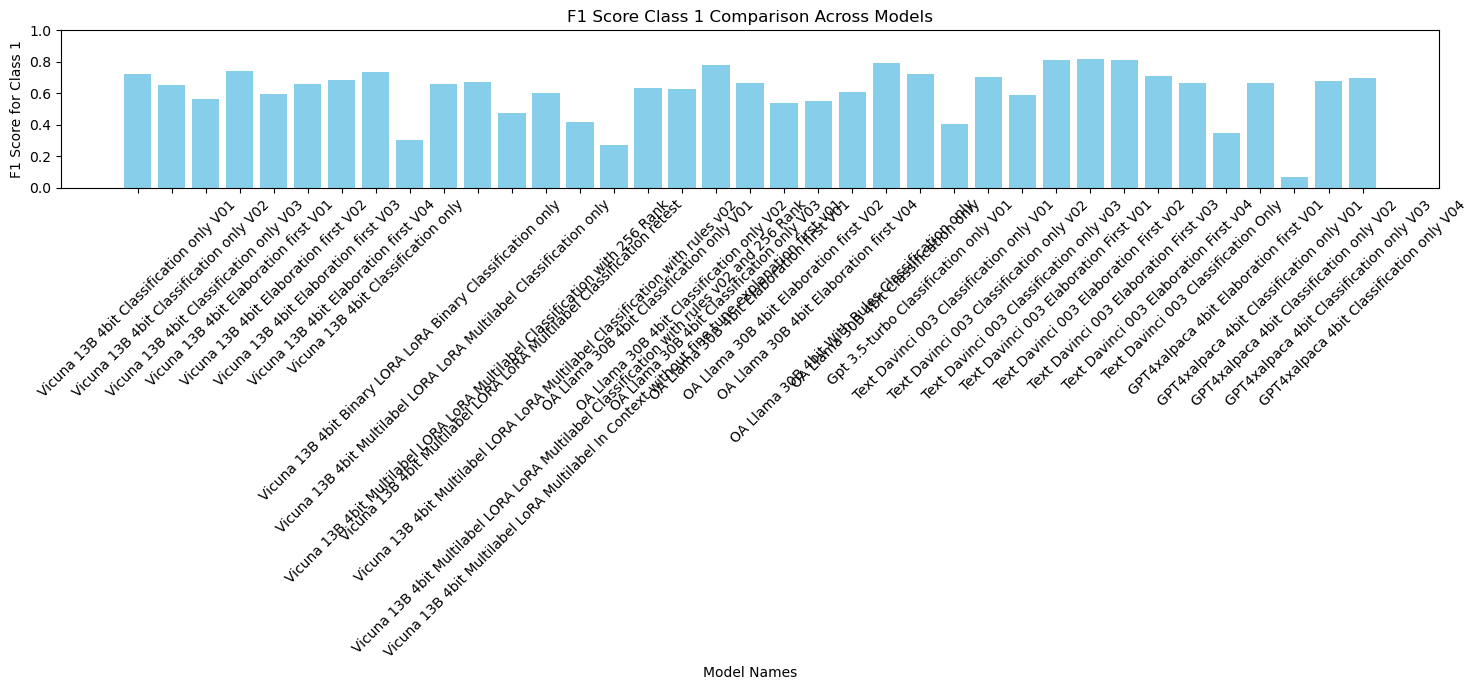

In [18]:
modelNames = [model["model_name"]+ " " + model["type"] for model in models]
f1Scores = [llm_utils.calculate_metrics_streamlit(model["data"]["binary_classification_reports"], 0.25)[1] for model in models]

plt.figure(figsize=(15, 7))
plt.bar(modelNames, f1Scores, color='skyblue')
plt.xlabel('Model Names')
plt.ylabel('F1 Score for Class 1')
plt.title('F1 Score Class 1 Comparison Across Models')
plt.ylim(0, 1)  # Assuming F1 score is between 0 and 1
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

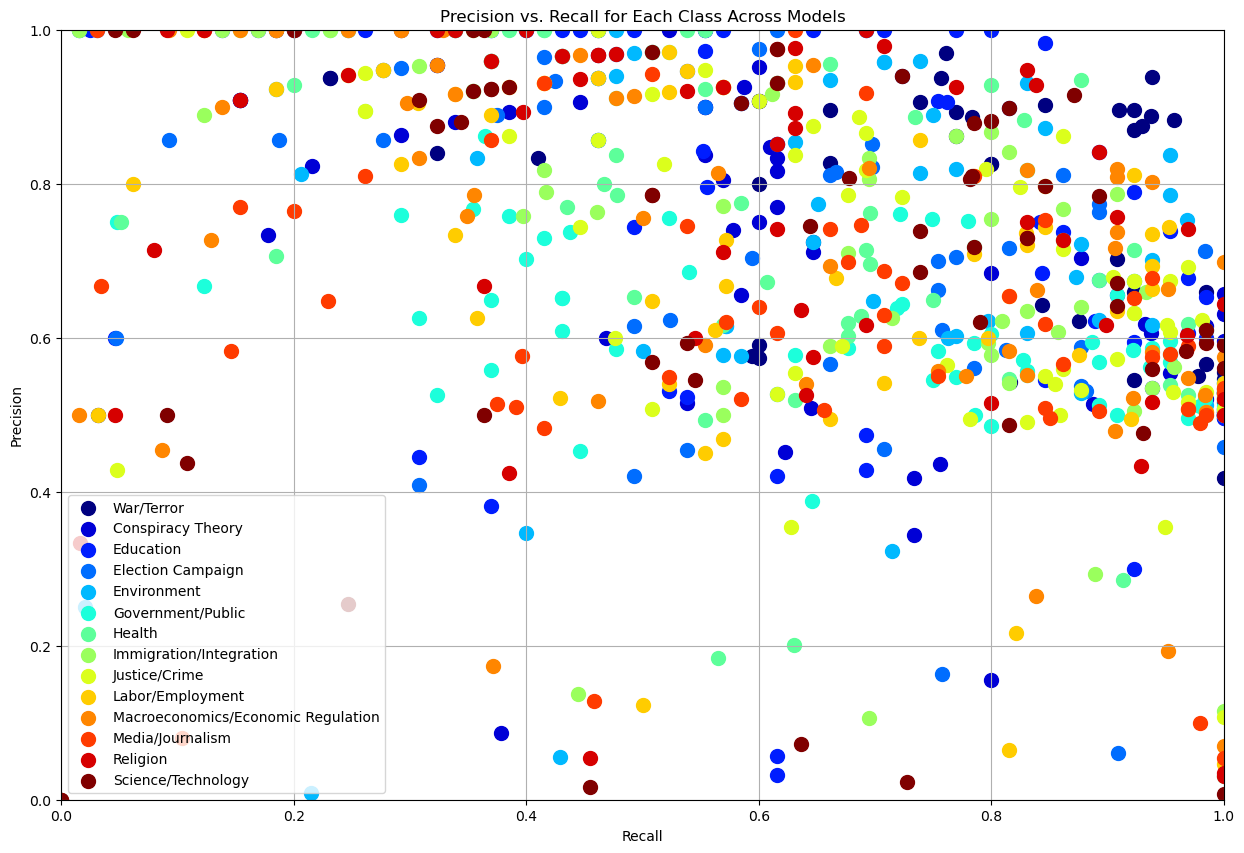

In [19]:
ALL_LABELS = prompt_utils.ALL_LABELS[0:-1]

precisions = [[] for _ in ALL_LABELS]
recalls = [[] for _ in ALL_LABELS]

# Extract precision and recall values for each class from all models
for idx, class_label in enumerate(ALL_LABELS):
    for model in models:
        report_df = model["data"]["binary_classification_reports"]
        precisions[idx].append(report_df[report_df.label == class_label]["precision_class_1"].values[0])
        recalls[idx].append(report_df[report_df.label == class_label]["recall_class_1"].values[0])

# Plotting
plt.figure(figsize=(15, 10))

# Scatter plot for each class
colors = plt.cm.jet(np.linspace(0, 1, len(ALL_LABELS)))
for idx, class_label in enumerate(ALL_LABELS):
    plt.scatter(recalls[idx], precisions[idx], label=class_label, color=colors[idx], s=100)

# Labels, title, and legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall for Each Class Across Models')
plt.legend(loc='lower left')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])

# Display the plot
plt.show()

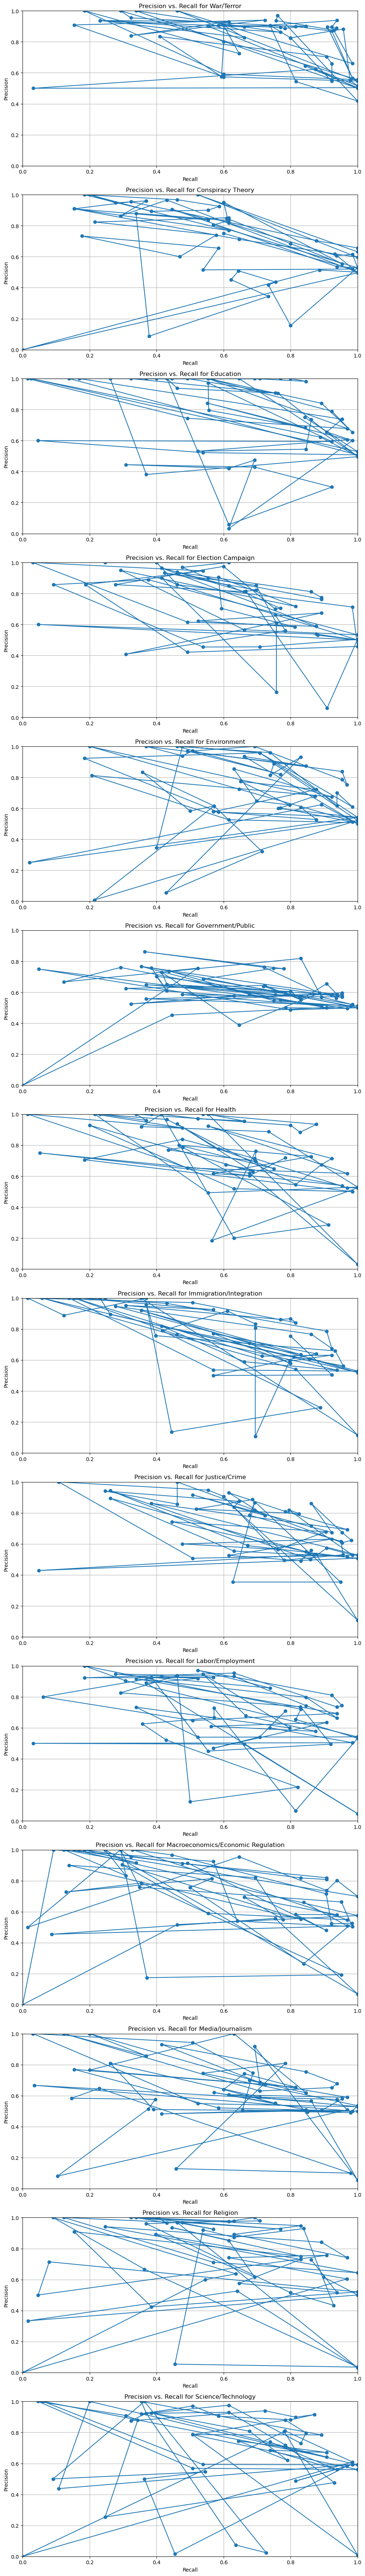

In [20]:
ALL_LABELS = prompt_utils.ALL_LABELS[0:-1]

precisions = [[] for _ in ALL_LABELS]
recalls = [[] for _ in ALL_LABELS]

# Extract precision and recall values for each class from all models
for idx, class_label in enumerate(ALL_LABELS):
    for model in models:
        report_df = model["data"]["binary_classification_reports"]
        precisions[idx].append(report_df[report_df.label == class_label]["precision_class_1"].values[0])
        recalls[idx].append(report_df[report_df.label == class_label]["recall_class_1"].values[0])

# Plotting
fig, axes = plt.subplots(len(ALL_LABELS), 1, figsize=(10, 5 * len(ALL_LABELS)))

for idx, class_label in enumerate(ALL_LABELS):
    ax = axes[idx]
    ax.plot(recalls[idx], precisions[idx], marker='o', linestyle='-')
    ax.set_title(f'Precision vs. Recall for {class_label}')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.grid(True)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

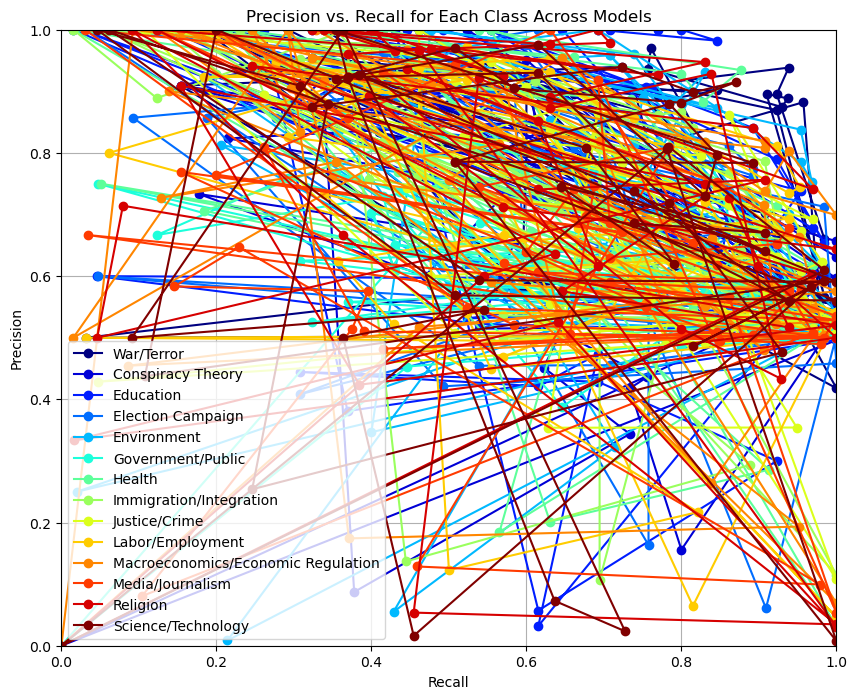

In [21]:
# Initialize lists to store precision and recall values for all classes
precisions = [[] for _ in ALL_LABELS]
recalls = [[] for _ in ALL_LABELS]
f1_scores = [[] for _ in ALL_LABELS]

# Extract precision and recall values for each class from all models
for idx, class_label in enumerate(ALL_LABELS):
    for model in models:
        report_df = model["data"]["binary_classification_reports"]
        precisions[idx].append(report_df[report_df.label == class_label]["precision_class_1"].values[0])
        recalls[idx].append(report_df[report_df.label == class_label]["recall_class_1"].values[0])
        f1_scores[idx].append(report_df[report_df.label == class_label]["f1_score_class_1"].values[0])

# Plotting
plt.figure(figsize=(10, 8))

colors = plt.cm.jet(np.linspace(0, 1, len(ALL_LABELS)))
for idx, class_label in enumerate(ALL_LABELS):
    plt.plot(recalls[idx], precisions[idx], label=class_label, color=colors[idx], marker='o', linestyle='-')

# Labels, title, and legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall for Each Class Across Models')
plt.legend(loc='lower left')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])

# Display the plot
plt.show()


In [22]:
# Check for NaN or missing values
for idx, class_label in enumerate(ALL_LABELS):
    if any(np.isnan(precisions[idx])) or any(np.isnan(recalls[idx])) or any(np.isnan(f1_scores[idx])):
        print(f"{class_label} has NaN or missing values.")

# Check the length of the lists
for idx, class_label in enumerate(ALL_LABELS):
    print(f"{class_label}: {len(precisions[idx])} precision values, {len(recalls[idx])} recall values, {len(f1_scores[idx])} F1-score values")

# Check for unique labels in ALL_LABELS and in the reports
unique_labels_in_reports = set()
for model in models:
    report_df = model["data"]["binary_classification_reports"]
    unique_labels_in_reports.update(report_df['label'].values)

print("Labels in ALL_LABELS not in reports:", set(ALL_LABELS) - unique_labels_in_reports)
print("Labels in reports not in ALL_LABELS:", unique_labels_in_reports - set(ALL_LABELS))

War/Terror: 56 precision values, 56 recall values, 56 F1-score values
Conspiracy Theory: 56 precision values, 56 recall values, 56 F1-score values
Education: 56 precision values, 56 recall values, 56 F1-score values
Election Campaign: 56 precision values, 56 recall values, 56 F1-score values
Environment: 56 precision values, 56 recall values, 56 F1-score values
Government/Public: 56 precision values, 56 recall values, 56 F1-score values
Health: 56 precision values, 56 recall values, 56 F1-score values
Immigration/Integration: 56 precision values, 56 recall values, 56 F1-score values
Justice/Crime: 56 precision values, 56 recall values, 56 F1-score values
Labor/Employment: 56 precision values, 56 recall values, 56 F1-score values
Macroeconomics/Economic Regulation: 56 precision values, 56 recall values, 56 F1-score values
Media/Journalism: 56 precision values, 56 recall values, 56 F1-score values
Religion: 56 precision values, 56 recall values, 56 F1-score values
Science/Technology: 56 

In [24]:
precisions

[[], [], [], [], [], [], [], [], [], [], [], [], [], []]

In [50]:
# Filter out NaN values
import plotly.graph_objects as go
import numpy as np
import colorsys

ALL_LABELS = prompt_utils.ALL_LABELS[0:-1]

precisions = [[] for _ in ALL_LABELS]
recalls = [[] for _ in ALL_LABELS]
f1_scores = [[] for _ in ALL_LABELS]

for idx, class_label in enumerate(ALL_LABELS):
    for model in models:
        report_df = model["data"]["binary_classification_reports"]
        precisions[idx].append(report_df[report_df.label == class_label]["precision_class_1"].values[0])
        recalls[idx].append(report_df[report_df.label == class_label]["recall_class_1"].values[0])
        f1_scores[idx].append(report_df[report_df.label == class_label]["f1_score_class_1"].values[0])


precisions = [[val for val in precision_list if not np.isnan(val)] for precision_list in precisions]
recalls = [[val for val in recall_list if not np.isnan(val)] for recall_list in recalls]
f1_scores = [[val for val in f1_list if not np.isnan(val)] for f1_list in f1_scores]

# Define a more scientific color palette
colors = [
    "#1f77b4",  # muted blue
    "#9467bd",  # muted purple
    "#8c564b",  # chestnut brown
    "#e377c2",  # raspberry
    "#7f7f7f",  # middle gray
    "#bcbd22",  # curry yellow-green
    "#17becf",  # blue-teal
    "#2ca02c",  # cooked asparagus green
    "#d62728",  # brick red
    "#ff7f0e",  # safety orange
    "#aec7e8",  # pastel blue
    "#c5b0d5",  # pastel purple
    "#c49c94",  # pastel brown
    "#f7b6d2",  # pastel pink
    "#c7c7c7"   # light gray
]

def darken_color(color, factor=0.9):
    r, g, b = [int(color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)]
    h, l, s = colorsys.rgb_to_hls(r/255.0, g/255.0, b/255.0)
    l = max(min(l * factor, 1.0), 0.0)
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return f"#{int(r * 255):02x}{int(g * 255):02x}{int(b * 255):02x}"

# Darken each color in the palette
darkened_colors = [darken_color(color) for color in colors]

# Create a dictionary to map each class label to a specific darkened color
color_mapping = {label: darkened_colors[i % len(darkened_colors)] for i, label in enumerate(ALL_LABELS)}


# Function to sort classes by descending median values
def sort_classes_by_median(values):
    median_values = [np.median(val) for val in values]
    sorted_indices = np.argsort(median_values)[::-1]  # Sort in descending order
    sorted_values = [values[i] for i in sorted_indices]
    sorted_labels = [ALL_LABELS[i] for i in sorted_indices]
    return sorted_values, sorted_labels

# Sort classes by median values for F1-scores, precision, and recall
sorted_f1_scores, sorted_f1_labels = sort_classes_by_median(f1_scores)
sorted_precisions, sorted_precision_labels = sort_classes_by_median(precisions)
sorted_recalls, sorted_recall_labels = sort_classes_by_median(recalls)

# Create enhanced boxplots using Plotly

fig_f1 = go.Figure()
for idx, class_label in enumerate(sorted_f1_labels):
    fig_f1.add_trace(go.Box(y=sorted_f1_scores[idx], name=class_label, boxmean=True, boxpoints='all', 
                            marker_color=color_mapping[class_label], line=dict(width=2)))
fig_f1.update_layout(title="F1-Score Distribution per Class", 
                     xaxis_title="F1-Score", 
                     yaxis_title="Class",
                     font=dict(family="Arial, sans-serif", size=12, color="black"),
                     xaxis=dict(tickfont=dict(size=11),
                                    title_standoff=1400),
                     yaxis=dict(tickfont=dict(size=14),
                                    title_standoff=50), 
                     width=1600,
                     height=400,
                     showlegend=False)
fig_f1.show()

# Boxplot for precision per class
fig_precision = go.Figure()
for idx, class_label in enumerate(sorted_precision_labels):
    fig_precision.add_trace(go.Box(y=sorted_precisions[idx], name=class_label, boxmean=True, boxpoints='all', 
                            marker_color=color_mapping[class_label], line=dict(width=2)))
fig_precision.update_layout(title="Precision Distribution per Class", 
                            xaxis_title="Precision", 
                            yaxis_title="Class",
                            font=dict(family="Arial, sans-serif", size=12, color="black"),
                            xaxis=dict(tickfont=dict(size=11),
                                            title_standoff=1400),
                            yaxis=dict(tickfont=dict(size=14),
                                            title_standoff=50), 
                            width=1600,
                            height=400,
                            showlegend=False)
fig_precision.show()

# Boxplot for recall per class
fig_recall = go.Figure()
for idx, class_label in enumerate(sorted_recall_labels):
    fig_recall.add_trace(go.Box(y=sorted_recalls[idx], name=class_label, boxmean=True, boxpoints='all', 
                                marker_color=color_mapping[class_label], line=dict(width=2)))
fig_recall.update_layout(title="Recall Distribution per Class", 
                         xaxis_title="Recall", 
                         yaxis_title="Class",
                        font=dict(family="Arial, sans-serif", size=12, color="black"),
                        xaxis=dict(tickfont=dict(size=11),
                                        title_standoff=1400),
                        yaxis=dict(tickfont=dict(size=14),
                                        title_standoff=50), 
                        width=1600,
                        height=400,
                        showlegend=False)
fig_recall.show()

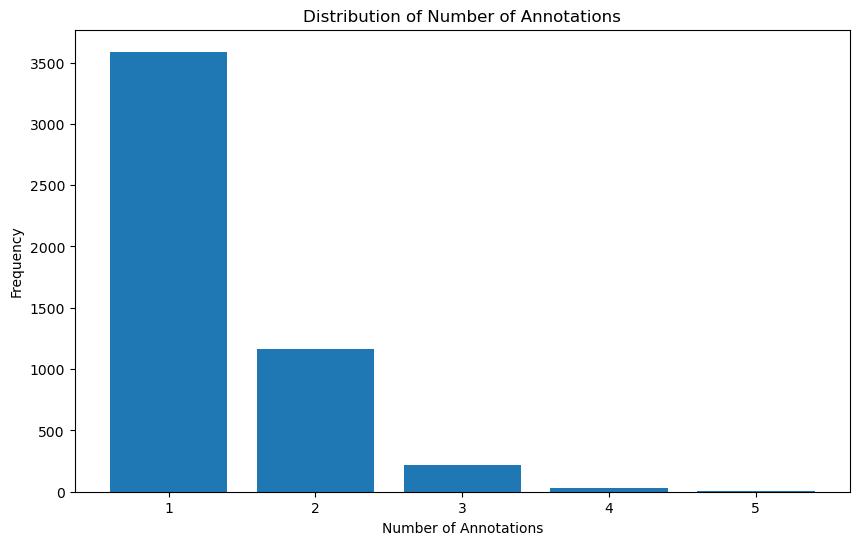

In [54]:
import json
# Define a list of filenames to load
labeled_data_filename = "../data/labeled_data/generic_test_0.json"
dfs = []
with open(labeled_data_filename) as f:
    data = json.load(f)
df = pd.DataFrame(data["train"])
dfs.append(df)
df = pd.DataFrame(data["test"])
dfs.append(df)
df = pd.DataFrame(data["valid"])
dfs.append(df)
df_all = pd.concat(dfs)
ALL_LABELS = prompt_utils.ALL_LABELS[:-1]
LOW_F1_LABELS = prompt_utils.LOW_F1_LABELS

df_all

# Compute the number of annotations for each row
df_all['num_annotations'] = df_all['annotations'].apply(len)

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(df_all['num_annotations'], bins=range(1, df_all['num_annotations'].max() + 2), align='left', rwidth=0.8)
plt.xlabel('Number of Annotations')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Annotations')
plt.xticks(range(1, df_all['num_annotations'].max() + 1))
plt.show()

In [61]:
# Filter rows with 5 annotations
entries_with_5_annotations = df_all[df_all['num_annotations'] == 5]
print(entries_with_5_annotations.annotations.values)
print(entries_with_5_annotations.text.values)


[list(['Government/Public', 'Health', 'Labor/Employment', 'Macroeconomics/Economic Regulation', 'Media/Journalism'])
 list(['Education', 'Government/Public', 'Immigration/Integration', 'Labor/Employment', 'War/Terror'])]
['Is a false choice noted @alferdez between "Social Isolation or economy". The US - which denied the severity of the pandemic and did not promote quarantine - has the highest number of deaths and also millions of unemployed. Industrial and media corporations lie. @AliciaCastroAR'
 'The #Syrian government is doing everything possible to make it easier to live for the refugees who managed to escape from the #Rukban camp. They are provided with jobs for adults and places in schools for children https://t.co/G55aK4ixkz']
